In [1]:
import pandas as pd
!pip install yahoo_fin --upgrade
import yahoo_fin
import numpy as np
from yahoo_fin.stock_info import get_data
import yfinance as yf

import math, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 2.3 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=7f5278a20e08fab62602e55668f755b3bb3eb9cdbb193dff5fb570c0ad82ae04
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
np.random.seed(42)

# Set random seed for PyTorch
torch.manual_seed(42)

In [3]:
#ENTER TICKER SYMBOL AND PULL BASIC COMPANY INFORMATION
stock_ticker = "AMZN"

#industry and sector information
stock = yf.Ticker(stock_ticker)
industry = stock.info['industry']
sector = stock.info['sector']

print(f"Ticker Symbol: {stock_ticker}")
print(f"Industry: {industry}")
print(f"Sector: {sector}")

Ticker Symbol: AMZN
Industry: Internet Retail
Sector: Consumer Cyclical


In [4]:
#PULL DATA AND ENGINEERED FEATURES USING YAHOO FINANCE API
stock_data = get_data(stock_ticker, start_date="01/01/2010", end_date="12/31/2019", index_as_date=True, interval="1d")

#log returns
stock_data['Log_Return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))

# 20 and 50 day moving day averages
stock_data['SMA_20'] = stock_data['close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['close'].rolling(window=50).mean()

#exponential moving average/EMA
stock_data['EMA_20'] = stock_data['close'].ewm(span=20, adjust=False).mean()

#relative strength index/RSI
window_length = 14
delta = stock_data['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
ema_down = down.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
rs = ema_up / ema_down
stock_data['RSI'] = 100 - (100 / (1 + rs))

#technical indicators
stock_data['MACD'] = stock_data['close'].ewm(span=12).mean() - stock_data['close'].ewm(span=26).mean()
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()
stock_data['Stochastic_%K'] = stock_data['close'].rolling(window=14).apply(lambda x: (x[-1] - x.min()) / (x.max() - x.min()), raw=True)
stock_data['Stochastic_%D'] = stock_data['Stochastic_%K'].rolling(window=3).mean()

#volume indicators
stock_data['Volume_SMA_20'] = stock_data['volume'].rolling(window=20).mean()
stock_data['Volume_Ratio'] = stock_data['volume'] / stock_data['Volume_SMA_20']

#volatility indicators
stock_data['Daily_Return_Volatility'] = stock_data['Log_Return'].rolling(window=14).std() * np.sqrt(252)
stock_data['Garman_Klass_Volatility'] = np.sqrt(252 * 0.5 * ((np.log(stock_data['close'] / stock_data['close'].shift(1)))**2).rolling(window=14).mean())

#momentum and trend indicators
stock_data['Price_Momentum'] = stock_data['close'].pct_change(periods=14)
stock_data['Rate_of_Change'] = stock_data['close'].pct_change(periods=9)
stock_data['Trend'] = np.where(stock_data['close'] > stock_data['close'].shift(1), 1, -1)

# seasonality indicators
stock_data['Day_of_Week'] = stock_data.index.dayofweek
stock_data['Month'] = stock_data.index.month

# information ratio
stock_data['info_ratio'] = stock_data['close'] / stock_data['close'].shift(14) / stock_data['Daily_Return_Volatility']

stock_data['close_change'] = stock_data['close'] - stock_data['close'].shift(1)
stock_data['range'] = stock_data['high'] - stock_data['low']
stock_data['ATR'] = stock_data['range'].rolling(window=14).mean()
stock_data['stoc_oscillator'] = (stock_data['close'] - stock_data['low'].rolling(window=14).min()) / (stock_data['high'].rolling(window=14).max() - stock_data['low'].rolling(window=14).min())

stock_data['cum_ret'] = stock_data['close'] / stock_data.iloc[-1]['open']

#data head
stock_data = stock_data.sort_index(ascending=False).dropna().iloc[::-1]
print(stock_data.head(100))

              open    high     low   close  adjclose     volume ticker  \
2010-03-16  6.5620  6.6145  6.5250  6.5895    6.5895   82650000   AMZN   
2010-03-17  6.6205  6.6345  6.5610  6.5670    6.5670   87176000   AMZN   
2010-03-18  6.5510  6.6425  6.5220  6.6380    6.6380  100426000   AMZN   
2010-03-19  6.6855  6.6855  6.4830  6.5175    6.5175  178100000   AMZN   
2010-03-22  6.5100  6.5480  6.4320  6.5235    6.5235  107668000   AMZN   
...            ...     ...     ...     ...       ...        ...    ...   
2010-07-30  5.7765  5.9370  5.7255  5.8945    5.8945  141550000   AMZN   
2010-08-02  5.9575  6.0190  5.8785  6.0035    6.0035  108874000   AMZN   
2010-08-03  6.0000  6.1435  5.9840  6.1210    6.1210  119076000   AMZN   
2010-08-04  6.1530  6.4235  6.1500  6.3790    6.3790  185416000   AMZN   
2010-08-05  6.3385  6.4000  6.2910  6.3915    6.3915   85646000   AMZN   

            Log_Return    SMA_20   SMA_50  ...  Rate_of_Change  Trend  \
2010-03-16    0.005021  6.236600  6.21

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [6]:
#preprocess data
stock_data = stock_data.drop(columns=['ticker'])
scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
stock_data_time = scaler.fit_transform(stock_data)
scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
scaler.fit(stock_data[['close']])
stock_data_time = stock_data_time.dropna()

print(stock_data_time.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2466 entries, 2010-03-16 to 2019-12-30
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     2466 non-null   float64
 1   high                     2466 non-null   float64
 2   low                      2466 non-null   float64
 3   close                    2466 non-null   float64
 4   adjclose                 2466 non-null   float64
 5   volume                   2466 non-null   float64
 6   Log_Return               2466 non-null   float64
 7   SMA_20                   2466 non-null   float64
 8   SMA_50                   2466 non-null   float64
 9   EMA_20                   2466 non-null   float64
 10  RSI                      2466 non-null   float64
 11  MACD                     2466 non-null   float64
 12  MACD_Signal              2466 non-null   float64
 13  Stochastic_%K            2466 non-null   float64
 14  Stocha

In [7]:
def load_data(stock, look_back):
    close_idx = stock.columns.get_loc('close')
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)

    test_size = int(0.2 * len(data))
    x_train = data[:-test_size, :-1, :]
    y_train = data[:-test_size, -1, close_idx]

    x_test = data[-test_size:, :-1]
    y_test = data[-test_size:, -1, close_idx]

    x_train = np.array(x_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)

    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

look_back = 61
x_train, y_train, x_test, y_test = load_data(stock_data_time, look_back)

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

batch_size = 32
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

x_train.shape = torch.Size([1924, 60, 30])
y_train.shape = torch.Size([1924])
x_test.shape = torch.Size([481, 60, 30])
y_test.shape = torch.Size([481])


In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1, sequence_length=60, output_size=1):
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.decoder = nn.Linear(feature_size, output_size)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(feature_size + 1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)

        self._init_weights()

    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(self.decoder.weight)

        self.fc1.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(self.fc1.weight)

        self.fc2.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

    def forward(self, src, prev_close):
        src = src.swapaxes(0, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = output[-1]

        output = torch.cat((output, prev_close.unsqueeze(1)), dim=1)

        output = self.relu(self.fc1(output))
        output = self.fc2(output)

        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1)
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask

In [16]:
def train(model, device, train_loader, optimizer, epoch, loss_function):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        prev_close = data[:, -1, -1]
        optimizer.zero_grad()
        output = model(data, prev_close)
        loss = loss_function(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        if (batch_idx + 1) % (len(train_loader) // 4) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)], Batch Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))
    return train_loss / len(train_loader)

In [17]:
def test(model, device, test_loader, epoch, loss_function):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            prev_close = data[:, -1, -1]
            output = model(data, prev_close)
            test_loss += loss_function(output.squeeze(), target).item()
    print('Test epoch: {}, Test batch loss: {:.4f}'.format(
        epoch, test_loss / len(test_loader)
    ))
    return test_loss / len(test_loader)

In [18]:
#model parameters
input_size = 30
hidden_size = 128 #could increase to 256 but VRAM will be limiter
output_size = 1
lstm_layers = 6
dropout = 0.1
num_epochs = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Transformer(
    feature_size=input_size,
    num_layers=lstm_layers,
    dropout=dropout,
    sequence_length=look_back - 1,
    output_size=output_size
    ).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=30, bias=True)
    (norm1): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
        )
        (linear1): Linear(in_features=30, out_fea

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 2 [448/1924 (23%)], Batch Loss: 0.009875
Train Epoch: 2 [928/1924 (48%)], Batch Loss: 0.004713
Train Epoch: 2 [1408/1924 (72%)], Batch Loss: 0.007527
Train Epoch: 2 [1888/1924 (97%)], Batch Loss: 0.003809
Test epoch: 2, Test batch loss: 0.0117
Train Epoch: 3 [448/1924 (23%)], Batch Loss: 0.007102
Train Epoch: 3 [928/1924 (48%)], Batch Loss: 0.008661
Train Epoch: 3 [1408/1924 (72%)], Batch Loss: 0.003666
Train Epoch: 3 [1888/1924 (97%)], Batch Loss: 0.006586
Test epoch: 3, Test batch loss: 0.0510
Train Epoch: 4 [448/1924 (23%)], Batch Loss: 0.004317
Train Epoch: 4 [928/1924 (48%)], Batch Loss: 0.004618
Train Epoch: 4 [1408/1924 (72%)], Batch Loss: 0.004505
Train Epoch: 4 [1888/1924 (97%)], Batch Loss: 0.005545
Test epoch: 4, Test batch loss: 0.0371
Train Epoch: 5 [448/1924 (23%)], Batch Loss: 0.004115
Train Epoch: 5 [928/1924 (48%)], Batch Loss: 0.002565
Train Epoch: 5 [1408/1924 (72%)], Batch Loss: 0.003033
Train Epoch: 5 [1888/1924 (97%)], Batch Loss: 0.002623
Test epoch:

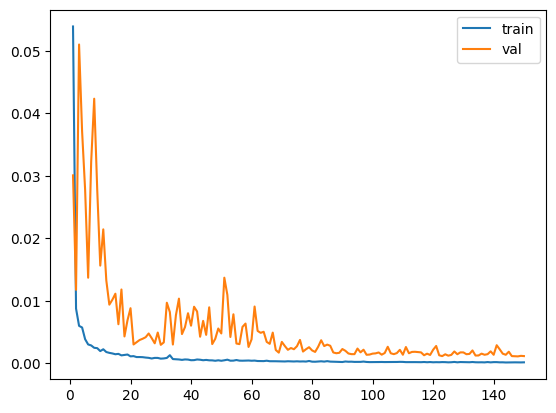

In [ ]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

train_losses = []
val_losses = []
for epoch in range(1, num_epochs + 1):
    train_losses.append(train(model, device, train_loader, optimizer, epoch, loss_fn))
    val_losses.append(test(model, device, test_loader, epoch, loss_fn))
    if (val_losses[-1] == min(val_losses)):
        torch.save(model.state_dict(), 'model_weights.pth')
plt.plot(np.arange(1, num_epochs + 1), train_losses, label=r'train')
plt.plot(np.arange(1, num_epochs + 1), val_losses, label=r'val')
plt.legend()

In [ ]:
# Make predictions
prev_close_train = x_train[:, -1, -1]  # Extract the previous day's closing price for training data
y_train_pred = model(x_train.to(device), prev_close_train.to(device)).to('cpu')
print(np.shape(y_train_pred))

prev_close_test = x_test[:, -1, -1]  # Extract the previous day's closing price for testing data
y_test_pred = model(x_test.to(device), prev_close_test.to(device)).to('cpu')

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy().reshape(-1, 1))[:, 0]
y_train = scaler.inverse_transform(y_train.detach().numpy().reshape(-1, 1))[:, 0]
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy().reshape(-1, 1))[:, 0]
y_test = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1))[:, 0]

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % trainScore)
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % testScore)

torch.Size([1924, 1])
Train Score: 0.49 RMSE
Test Score: 1.68 RMSE


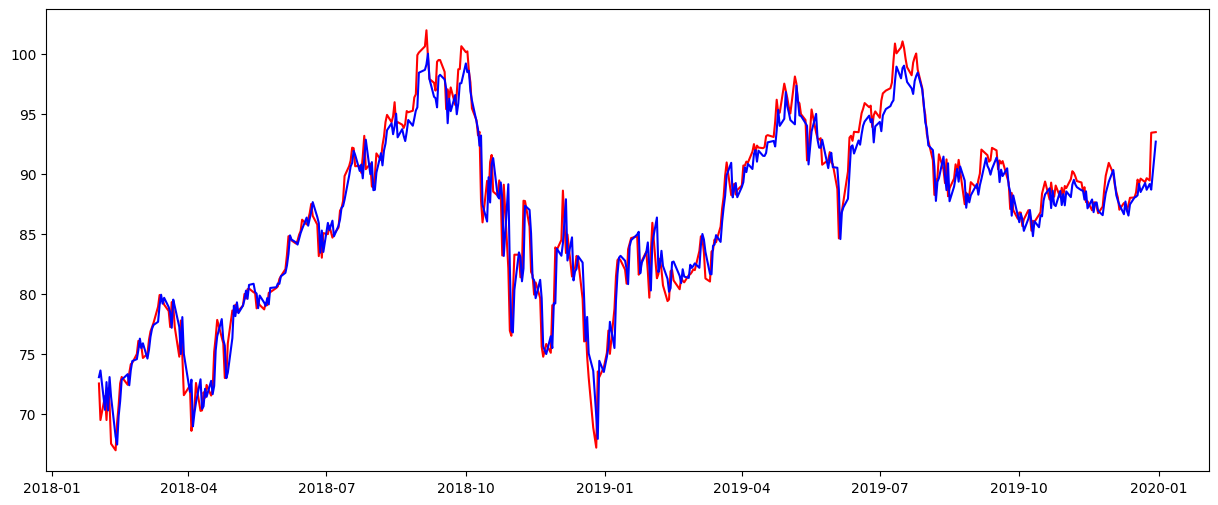

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test, color = 'red', label = 'real')
axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'pred')
plt.show()

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

156